# Denoising with linear model using functions from Vobi One repository

Necessary libraries

In [2]:
from numpy import array, arange, zeros, cos, sin, exp, hstack, nonzero, transpose, argmax
from math import pi, ceil, pow
import numpy as np
import matplotlib.pyplot as plt
import h5py

Data Loading

In [4]:
raw_blank_path = r'/media/mathis/Data/Mathis/raw_blank_z210908.npy' #change it to adapt to your directories
raw_evoked_path = r'/media/mathis/Data/Mathis/raw_pos4_z210908.npy'

Raw_blank = np.load(raw_blank_path)
Raw_evoked = np.load(raw_evoked_path)

In [5]:
anesth_blank_path = r'/media/mathis/Data/Mathis/signal_240306_blank.mat' #change it to adapt to your directories
anesth_evokedD_path = r'/media/mathis/Data/Mathis/signal_240306_gaussianD.mat'

file_anesth_blank = h5py.File(anesth_blank_path)['signal']
file_anesth_evokedD = h5py.File(anesth_evokedD_path)['signal']

anesth_blank = np.array(file_anesth_blank)
anesth_evokedD = np.array(file_anesth_evokedD)

## 0 : Necessary functions from the repo

### from https://github.com/SylvainTakerkart/vobi_one/blob/master/lib/python2.5/site-packages/oidata/glm.py

In [6]:
def ols(Y, X, axis=0):
    """
    beta, nvbeta, s2, dof = ols(Y, X, axis=0)

    Essentially, compute pinv(X)*Y
    """
    ndims = len(Y.shape)
    pX = np.linalg.pinv(X)
    beta = np.rollaxis(np.inner(pX, np.rollaxis(Y, axis, ndims)), 0, axis+1)
    nvbeta = np.inner(pX, pX)
    res = Y - np.rollaxis(np.inner(X, np.rollaxis(beta, axis, ndims)), 0, axis+1)
    n = res.shape[axis]
    s2 = (res**2).sum(axis) / float(n-X.shape[1])
    dof = float(X.shape[0] - X.shape[1])
    return beta, nvbeta, s2, dof

### from https://github.com/SylvainTakerkart/vobi_one/blob/master/lib/python2.5/site-packages/oidata/model_definition.py

In [7]:
def fourier_coeffs(N,f,time):
    """Creates fourier coefficients for environmental and physiological noise

    Parameters
    ----------
    N : int
        Fourier order of the corresponding frequency
    f : float
        Fondamental frequency
    time : vector
        Time vector


    Returns
    ----------
    X : array of float
        Concatenation of each oscillator component

    Notes
    ----------
    The fourier coefficients used are :math:`c_{n}^{k}=cos(2 n \pi f_{k} t)` and :math:`s_{n}^{k}=sin(2 n \pi k_{k} t)`.

    The output is then defined as the concatenation of column vectors :math:`c_{i}^{k}` and :math:`s_{i}^{k}`, :math:`i=[1 \dots N_{k}]` :
    
    .. math::

        X_{1}^{k}=[c_{1}^{k} \ s_{1}^{k} \dots c_{N_{k}}^{k} \ s_{N_{k}}^{k}]

    Examples
    ----------
    >>> from linear_model import fourier_coeffs
    >>> from numpy import arange
    >>> import param_conf as conf
    >>> time_vector=arange(0,(conf.dt),(1/conf.fe))
    >>> X1=fourier_coeffs(conf.N1,conf.f1,time_vector)
    >>> X1
    array([[ 1.        ,  0.        ,  1.        , ...,  0.        ,
             1.        ,  0.        ],
           [ 0.84125353,  0.54064082,  0.41541501, ...,  0.75574957,
            -0.95949297,  0.28173256],
           [ 0.41541501,  0.909632  , -0.65486073, ..., -0.98982144,
             0.84125353, -0.54064082],
           ..., 
           [-0.14231484, -0.98982144, -0.95949297, ..., -0.54064082,
            -0.65486073, -0.75574957],
           [ 0.41541501, -0.909632  , -0.65486073, ...,  0.98982144,
             0.84125353,  0.54064082],
           [ 0.84125353, -0.54064082,  0.41541501, ..., -0.75574957,
            -0.95949297, -0.28173256]])

    """

    X=zeros((time.shape[0],N*2)) # X1_k initialisation
    
    range_N=arange(1,N+1,1) # Creating a vector going from 1 to N with step = 1
    j=0
    for n in range_N: # from 1 to N
        X[:,j]=cos(2*pi*n*f*time) # Cosinus component
        X[:,j+1]=sin(2*pi*n*f*time) # Sinus component
        j=j+2
        
    return X

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_5750/2018861608.py:2: SyntaxWarning: invalid escape sequence '\p'
  """Creates fourier coefficients for environmental and physiological noise


In [8]:
def mod_bruits(N,f,time):
    """Creates fourier coefficients of a list of frequencies and concatenates them into an array
    
    Parameters
    ----------
    N : list of int
                Fourier orders of the corresponding frequency
        f : list of float
                Fondamental frequencies
    time : vector
        Time vector

    Returns
    ----------
    X1 : array of float

    Notes
    ----------

    .. math::

        X_{1} = [X_{1,1} \ X_{1,2} \dots X_{1,k}]

    """

    i=0
    while i<(len(N)):
        X=fourier_coeffs(N[i],f[i],time) # Creating fourier coefficients

        if i==0:
            X1=X # X1 initialisation (for the first loop)
        else:
            X1=hstack((X1,X)) # Concatenation of X and X1
        i=i+1

    return X1

<>:2: SyntaxWarning: invalid escape sequence '\ '
<>:2: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_5750/3698477746.py:2: SyntaxWarning: invalid escape sequence '\ '
  """Creates fourier coefficients of a list of frequencies and concatenates them into an array


In [9]:
def dye_bleaching(tau,time):
    """
    Creates the exponential decrease of dye

    Parameters
    ----------
    tau : float
        Time constant of exponential decrease
    time : vector
        Time vector

    Returns
    ----------
    X2 : vector of int
        The exponential decrease
    """
    X2 = zeros( ( time.shape[0] , 1 ) ) # Vector initialisation. It has the same size as the time vector
    X2[:,0] = exp(-(time/tau)) - 1. # Creating of dye bleaching function

    return X2

In [10]:
def range_alpha(alpha_min,alpha_max,time):
    """Create a time-range vector included between an alpha min and an alpha max
    New version (STt 2012/10/24) to accelarate things: fixed number of example
    shapes are generated (around 10000); the number of steps for each parameter
    is automatically chosen to do so...

    Parameters
    ----------
    alpha_min : float
        The minimum time of the vector
    alpha_max : float
        The maximum time of the vector
    time : vector
        Time vector

    Returns
    -------
        alpha : vector
            Time-range vector
    """
    # we browse the parameters in the following way, to be efficient:
    # we will generate a constant number of simulated shapes, and compute
    # the step numbers, parameter by parameter, to generate this
    # for each type of parameters (the first 6 are temporal parameters, the last 2
    # are amplitude parameter), the parameter with the widest range is split into
    # 10 steps, and the other parameters are split proportionnally

    total_nbr_simulated_shapes = 10000

    # normalize parameter ranges in two range: the temporal parameters (first 6),
    # and the amplitude parameters (last 2)

    alpha_range = array(alpha_max) - array(alpha_min)

    normed_alpha_range = zeros(len(alpha_min))

    temp_max_index = argmax(alpha_range[0:6])
    amp_max_index = argmax(alpha_range[6:8]) + 6
    if alpha_range[temp_max_index]:
        for i in range(6):
            normed_alpha_range[i] = alpha_range[i] / alpha_range[temp_max_index]
    if alpha_range[amp_max_index]:
        for i in range(6,8):
            normed_alpha_range[i] = alpha_range[i] / alpha_range[amp_max_index]

    nonnull_range = normed_alpha_range[nonzero(normed_alpha_range)]

    if len(nonnull_range):

        c = 1. / nonnull_range.prod()
        
        e = 1. / len(nonnull_range)
        
        max_step_number = pow( c * total_nbr_simulated_shapes, e )
        
        step_numbers = zeros(len(alpha_min), dtype=int)
        for i in range(len(alpha_min)):
            step_numbers[i] = int(ceil(max_step_number * normed_alpha_range[i]))
            
        alpha=[] # alpha initialization
        i=0 # number of parameters (at the moment: there are 7 alpha parameters
        
        while i<len(alpha_min):
            alpha_i=[] # alpha_i initialization

            if alpha_min[i] == alpha_max[i]:
                # if one value only, then just use this one!
                alpha_i.append(alpha_min[i])
            else:
                for s in range(step_numbers[i]):
                    alpha_i.append(alpha_min[i] + s * (alpha_max[i] - alpha_min[i]) / step_numbers[i])

            alpha_i=array(transpose([alpha_i]))
            alpha.append(alpha_i)
            i=i+1

    else: # there's not actual range of parameters, the user wants to work with a single fixed shape
        alpha = alpha_min # which is equal to alpha_max


    return alpha

In [11]:
def concat_alpha(A,B):
    """Concatenates a matrix and a vector to one matrix

    Parameters
    ----------
    A : numpy array
        A matrix
    B : numpy vector
        A vector

    Returns
    -------
    alpha : numpy array
        The concatenation of A and B
    
    """
    
    alpha=zeros(((len(A)*len(B)),len(A[0])+1)) # alpha initialization

    i=0
    while i<len(B):
        alpha[i*len(A):(i+1)*len(A),0:len(A[0])]=A
        alpha[i*len(A):(i+1)*len(A),len(A[0])]=B[i,0]
        i=i+1

    return alpha

In [12]:
def mod_response(alpha,time):
    """Creates the example-shapes response

    Parameters
    ----------
    alpha : numpy vector
        The whole values that can take alpha
        Created by range_alpha(...)
    time : numpy vector
        Time vector

    Returns
    -------
    r_alpha : numpy array
        Response-shapes components
    """
    r_alpha=zeros((time.shape[0],len(alpha))) # r_alpha initialization
    
    range_size=arange(len(alpha)) # range_size initialization
    
    invalid=[] # Bad shapes list
    invalid_id=[] # Bad shapes identity list
    i=0 # Number of correct shape    
    for a in range_size: # For each shape
        if (alpha[a,0]+alpha[a,1]+alpha[a,2]+alpha[a,3]+alpha[a,4]+alpha[a,5])<time[-1]:

            # delay before the response starts: stays at zero
            c1=nonzero(time>alpha[a,0])

            # first part of the negative dip; amplitude is -beta = -alpha[,6]
            c2=nonzero(time>(alpha[a,0]+alpha[a,1]))
            r_alpha[c1[0][0]:c2[0][0],i] = alpha[a,6] * (cos(pi*((time[c1[0][0]:c2[0][0]]-alpha[a,0])/alpha[a,1])) - 1 ) / 2

            # rise from negative dip to plateau; amplitude of plateau is +1
            c3=nonzero(time>(alpha[a,0]+alpha[a,1]+alpha[a,2]))
            r_alpha[c2[0][0]:c3[0][0],i] = (1 - alpha[a,6]) / 2 - (1 + alpha[a,6]) * cos(pi*((time[c2[0][0]:c3[0][0]]-alpha[a,0]-alpha[a,1])/alpha[a,2])) / 2

            # plateau
            c4=nonzero(time>(alpha[a,0]+alpha[a,1]+alpha[a,2]+alpha[a,3]))
            r_alpha[c3[0][0]:c4[0][0],i]=1.

            # decrease from plateau to second negative dip: amplitude of dip is -gamma = -alpha[,7]
            c5=nonzero(time>(alpha[a,0]+alpha[a,1]+alpha[a,2]+alpha[a,3]+alpha[a,4]))
            r_alpha[c4[0][0]:c5[0][0],i] = (1 - alpha[a,7]) / 2 + (1 + alpha[a,7]) * cos(pi*((time[c4[0][0]:c5[0][0]]-alpha[a,0]-alpha[a,1]-alpha[a,2]-alpha[a,3])/alpha[a,4])) / 2

            # rise from second negative dip to rest activity (zero!)
            c6=nonzero(time>(alpha[a,0]+alpha[a,1]+alpha[a,2]+alpha[a,3]+alpha[a,4]+alpha[a,5]))
            r_alpha[c5[0][0]:c6[0][0],i] = - alpha[a,7] * (1 + cos(pi*((time[c5[0][0]:c6[0][0]]-alpha[a,0]-alpha[a,1]-alpha[a,2]-alpha[a,3]-alpha[a,4])/alpha[a,5])) ) / 2

            i=i+1 # Increase of correct shape
        else: # The shape is invalid
            invalid_id.append(a) # Add identity of bad shape
            invalid.append([alpha[a,0],alpha[a,1],alpha[a,2],alpha[a,3],alpha[a,4],alpha[a,5],alpha[a,6],alpha[a,7]]) # Add her values
    return r_alpha[:,0:i],invalid,invalid_id

## 1 : Parameters definition

Inspired from https://github.com/SylvainTakerkart/vobi_one/blob/master/examples/good_updated_validated_scripts/script1_lm_tbin1_sbin2_allestim01.py for the format, the frequencies and order proposed are extracted from the paper of Reynaud et al., and the range proposed are identified at rough guess, based on time series in raw data

In [13]:
N_trials, Nt, Nx, Ny = Raw_evoked.shape
L = 10
fs = 100 #Hz
f = np.array([2.3, 3.5, 10, 12]) #fundamental frequencies 
N = np.array([  2,   1,  5,  1])  #associated orders
time = np.array([i/fs for i in range(Nt)])
tau = .95 #s
alpha_min = [0.17, 0., 0.02, 0.05, 0.05, 0., 0., 0.]  #range proposed for alpha parameters        
alpha_max = [0.25, 0., 0.08, 0.15, 0.15, 0., 0., 0.]             

## 2 : Noise regressors

for this section and the next one (response regressors), check "create_model_definition" (line 426) here https://github.com/SylvainTakerkart/vobi_one/blob/master/lib/python2.5/site-packages/oidata/oisession.py

In [14]:
X0 = np.ones([Nt,1])

In [15]:
X1 = mod_bruits(N, f, time)

In [16]:
X2 = dye_bleaching(tau, time)

In [17]:
X_noise = np.concatenate( ( X0, X1, X2), 1)

## 3 : Response regressors

In [18]:
alpha_range=range_alpha(alpha_min,alpha_max,time)

In [19]:
alpha = alpha_range[0]
for a in range(len(alpha_range)-1):
    alpha = concat_alpha(alpha,alpha_range[a+1]) # Concatenation of the submatrix

r_alpha=mod_response(alpha,time)[0]

In [20]:
X3=np.linalg.svd(r_alpha,full_matrices=False) # Eigenvectors
X3=X3[0][:,0:L]

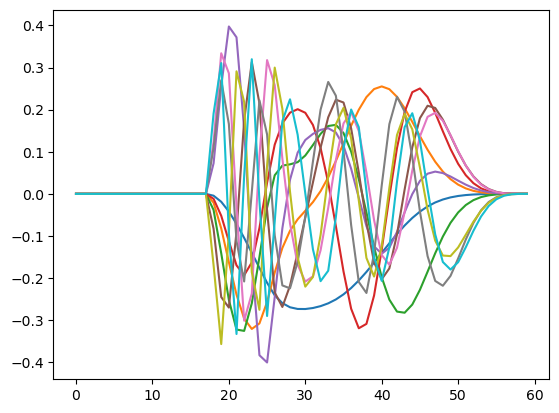

In [21]:
plt.figure()
for l in range(L):
    plt.plot(X3[:,l])

In [22]:
X = np.concatenate( ( X0, X1, X2, X3), 1)

## 4 : Linear regression, naive approach

### 4.1 : For a single pixel

In [23]:
Y=Raw_evoked[8, :, 200, 201]

refers to the "fit" function starting from line 35 here https://github.com/SylvainTakerkart/vobi_one/blob/master/lib/python2.5/site-packages/oidata/glm.py

In [24]:
betas, beta_, s2, dof = ols(Y, X)

#### Signal reconstruction

In [25]:
pred = X@betas

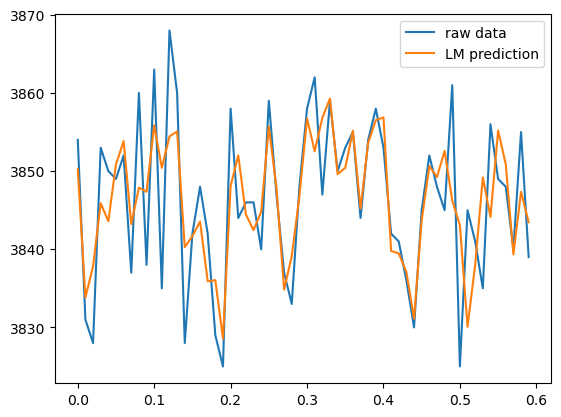

In [26]:
plt.plot(time, Y, label='raw data')
plt.plot(time,pred, label='LM prediction')
plt.legend()

#### Residuals analysis

In [27]:
residuals = Y - pred
mu_res, std_res = np.mean(residuals), np.std(residuals)

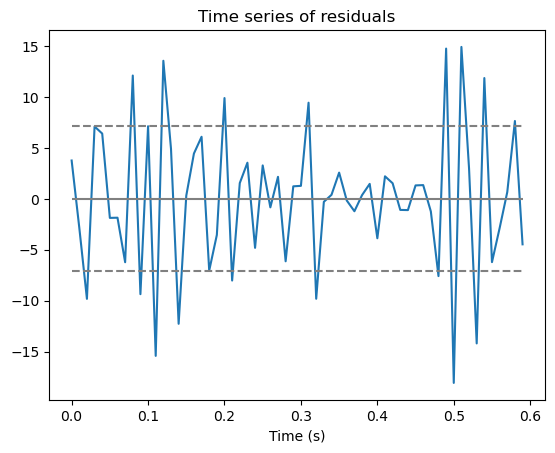

In [28]:
plt.title('Time series of residuals')
plt.xlabel('Time (s)')
plt.plot(time, residuals)
plt.hlines(mu_res, time[0], time[-1], 'gray')
plt.hlines(mu_res+std_res, time[0], time[-1], 'gray', linestyle='dashed')
plt.hlines(mu_res-std_res, time[0], time[-1], 'gray', linestyle='dashed')

In [29]:
freqs = np.fft.fftfreq(Nt, d=1/fs)[1:Nt//2-1]

ft_y = np.fft.fft(Y)
ft_pred = np.fft.fft(pred)
ft_res = np.fft.fft(residuals)

ps_y = np.abs(ft_y)**2
ps_pred = np.abs(ft_pred)**2
ps_res = np.abs(ft_res)**2

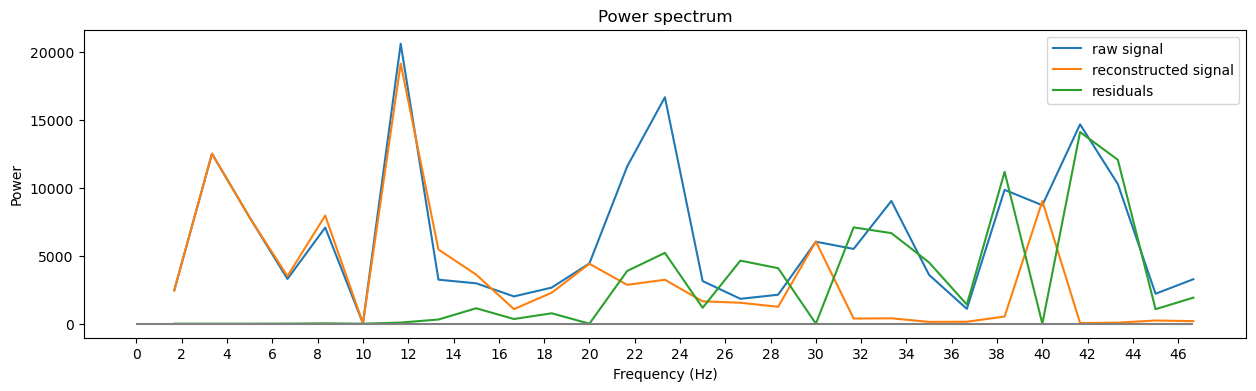

In [30]:
plt.figure(figsize=(15,4))
plt.title('Power spectrum')
plt.plot(freqs,ps_y[1:Nt//2-1], label='raw signal')
plt.plot(freqs,ps_pred[1:Nt//2-1], label='reconstructed signal')
plt.plot(freqs,ps_res[1:Nt//2-1], label='residuals')
plt.hlines(0,0,freqs[-1],'gray')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xticks(range(0,round(freqs[-1]),2))
plt.legend()
plt.show()

Reconstructed signals correctly covers the low frequencies of the original signal but most of the high frequencies are lost to the residuals...

#### $R^2$ of the fit:

In [62]:
res_ss = ((residuals)** 2).sum()
tot_ss = ((Y - Y.mean()) ** 2).sum()
score = 1-res_ss/tot_ss
print(f'R2 = {round(score,2)}')

R2 = 0.61


In [32]:
noise = X[:, :-L]@betas[:-L]

In [33]:
denoised = Y - noise

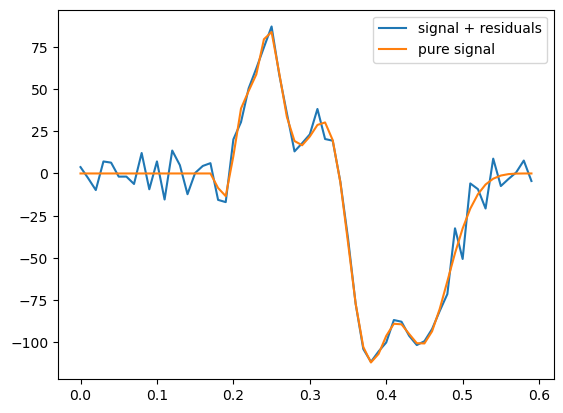

In [34]:
plt.plot(time, denoised, label='signal + residuals')
plt.plot(time, denoised-residuals, label='pure signal')
plt.legend()

### 4.2 : For a whole trial

In [63]:
Trial = np.copy(Raw_evoked[8])

#### Masking the border

In [64]:
def circular_mask(shape, center, radius):
    Y, X = np.ogrid[:shape[0], :shape[1]]
    return ((X - center[0]) ** 2 + (Y - center[1]) ** 2) <= radius ** 2

mask_boolean = circular_mask(Trial.shape[1:], center=(220,190), radius=175)

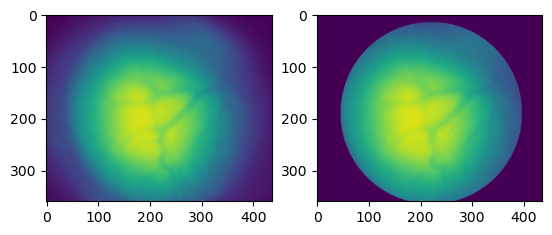

In [65]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(Trial[0])
ax2.imshow(Trial[0]*mask_boolean)

#### Denoising loop over all valid pixels ( /!\ the run is ~30s long)

In [66]:
Trial_denoised = np.zeros_like(Trial)
Score=[]
for i in range(Nx):
    for j in range(Ny):
        if mask_boolean[i,j]:
            signal = Trial[:, i, j]
            betas_, nvbeta_, s2_, dof_ = ols(signal, X)
            noise_ = X[:, :-L]@betas_[:-L]
            Trial_denoised[:, i, j] =(signal - noise_)/betas_[0]
            res = signal - X@betas_
            res_ss = ((res)** 2).sum()
            tot_ss = ((signal - signal.mean()) ** 2).sum()
            if tot_ss>0:
                score_ = 1-res_ss/tot_ss
                Score.append(score_)
        else:
            Trial_denoised[:, i, j] = np.nan
Score=np.array(Score)

R2

In [67]:
Score.mean()

0.504573398150761

#### plot the result for a few ones

Text(0.5, 0, 'Frames')

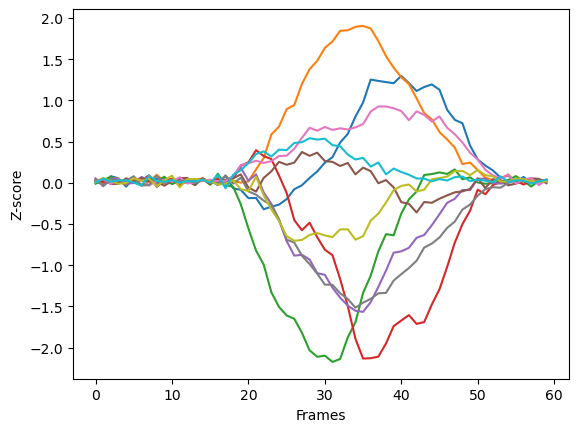

In [68]:
Trial_denoised = (Trial_denoised - np.nanmean(Trial_denoised))/np.nanstd(Trial_denoised)
plt.plot(Trial_denoised[:, 200:210, 200])
plt.ylabel("Z-score")
plt.xlabel('Frames')

It appears that numerous pixels have a "negative  response shape" after the denoising...

#### plot the denoised images

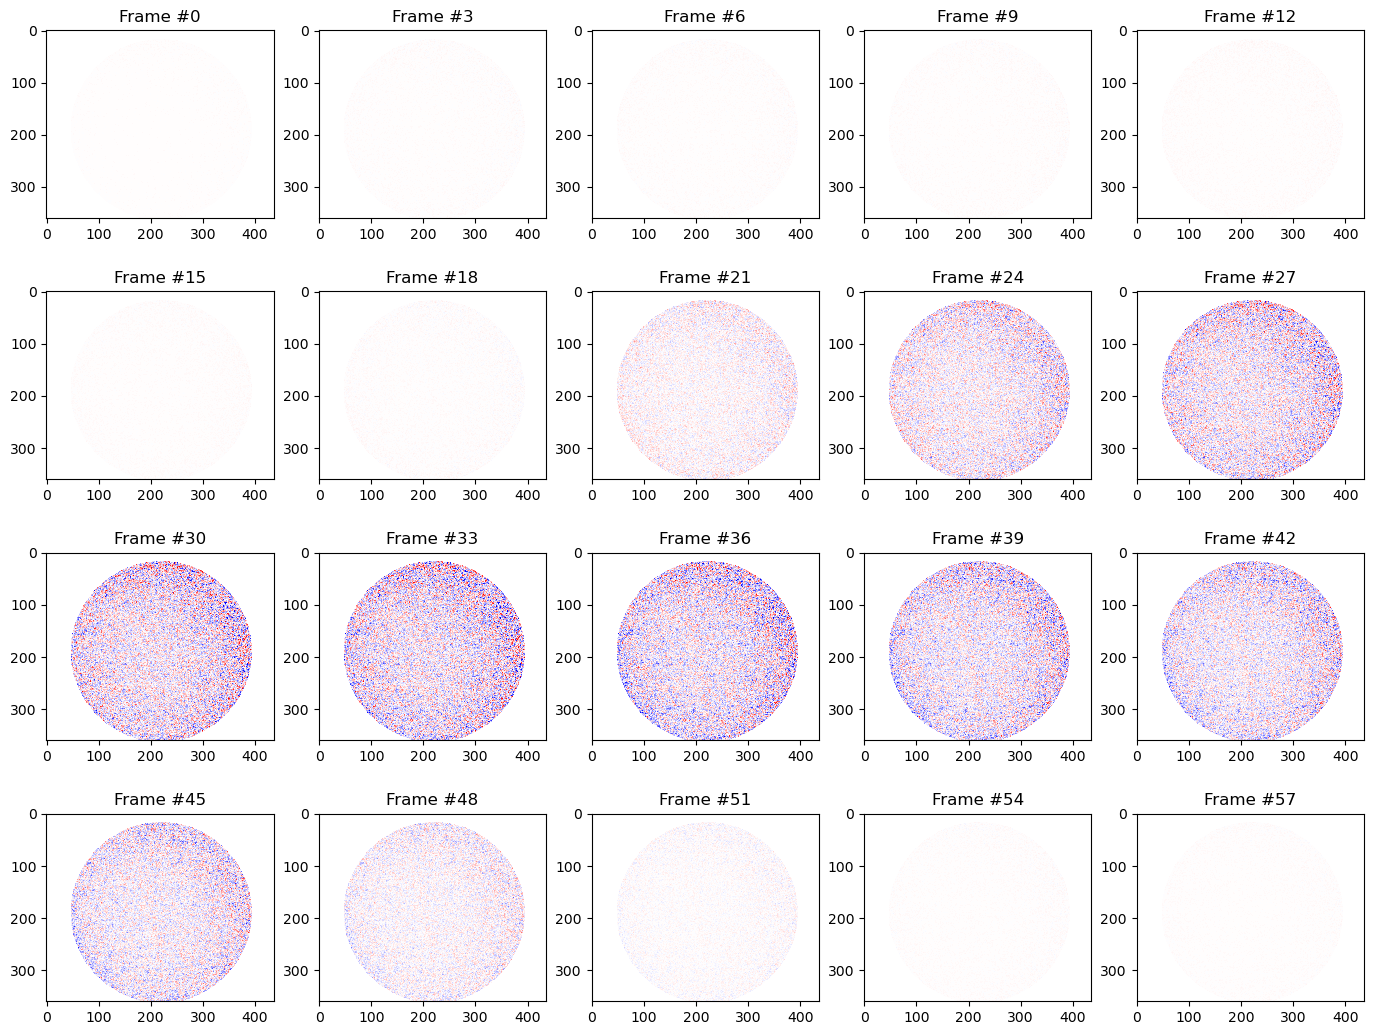

In [69]:
fig, axs = plt.subplots(4,5, figsize=(17,13))
for k in range(60):
    if k%3==0:
        ind=k//3
        axs[ind//5, ind%5].imshow(Trial_denoised[k], cmap='seismic', vmin=-5, vmax=5)
        axs[ind//5, ind%5].set_title("Frame #"+str(k))

Same problem as mentionned before: all the pixels seem to take a response shape, we cannot see the wave initiation and propagation. This is due to the heartbeat pulse, which is synchronised witht the emergence of the wave. So, the linear model decomposition attributes alpha-response components to all pixels whereas it's only the heartbeat pulse.

#### Time series plot of the mean $\frac{\Delta F}{F}$ signal

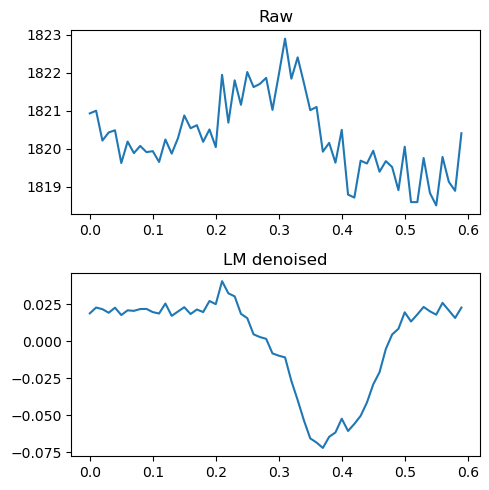

In [70]:
ts = np.nanmean(Trial, axis=(1,2))
ts_denoised = np.nanmean(Trial_denoised, axis=(1,2))

fig, (ax1,ax2)=plt.subplots(2,1, figsize=(5,5), tight_layout=True)
ax1.set_title('Raw')
ax1.plot(time, ts)
ax2.set_title('LM denoised')
ax2.plot(time, ts_denoised)

At least bleaching seems to be correctly removed... It doesn't work since it appears that there is an overlap between heartbeat activity and the response shape we want to fit. To avoid that, we'll try to first remove the heartbeat activity with a first Linear Model, and then a second one to extract the response shape. 

## 5 : Linear regression, smarter approach 

In [43]:
X1_heart = X1[:, :N[0]]
X1_others = X1[:, 2*N[0]:]

In [44]:
pre_X = np.concatenate( ( X0, X1_heart), 1)

### 5.1 : At the single pixel level

In [45]:
Y=Raw_evoked[8, :, 202, 201]

In [46]:
betas_1, _, _, _ = ols(Y, pre_X)

In [47]:
heartbeat = pre_X[:, 1:]@betas_1[1:]

In [48]:
Y2 = Y - pre_X@betas_1

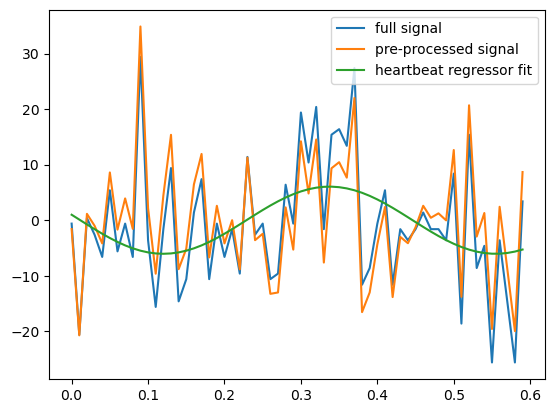

In [49]:
plt.plot(time, Y-betas_1[0], label='full signal')
plt.plot(time, Y2, label='pre-processed signal')
plt.plot(time,heartbeat, label='heartbeat regressor fit')
plt.legend()

In [50]:
post_X = np.concatenate( ( X0, X1_others, X2, X3), 1)

In [51]:
betas_2, _, _, _ = ols(Y2, post_X)

In [52]:
Y3 = post_X@betas_2

In [53]:
resi = Y2 - Y3

In [54]:
noise = post_X[:, :-L]@betas_2[:-L]

In [55]:
denoise = Y3 - noise

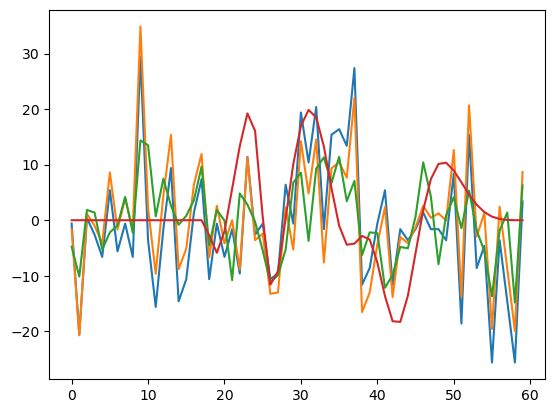

In [71]:
plt.plot(Y-betas_1[0])
plt.plot(Y2)
plt.plot(Y3)
plt.plot(denoise)

### 5.1 : For a whole trial

In [57]:
Trial_smart = np.copy(Raw_evoked[8])

In [58]:
Trial_denoised_smart = np.zeros_like(Trial_smart)
for i in range(Nx):
    for j in range(Ny):
        if mask_boolean[i,j]:
            signal = Trial_smart[:, i, j]
            #pre-processing: remove heartbeat
            betas_h, _, _, _ = ols(signal,pre_X)
            baseline = betas_h[0]
            heart_noise = pre_X[:, 1:]@betas_h[1:]
            signal_dh = signal-heart_noise 
            #then regression with remaining regressors
            beta, _, _, _ = ols(signal_dh,post_X)
            noise_ = post_X[:, :-L]@beta[:-L]
            Trial_denoised_smart[:, i, j] =(signal_dh - noise_)/beta[0]
        else:
            Trial_denoised_smart[:, i, j] = np.nan

In [74]:
pre_X.shape

(60, 3)

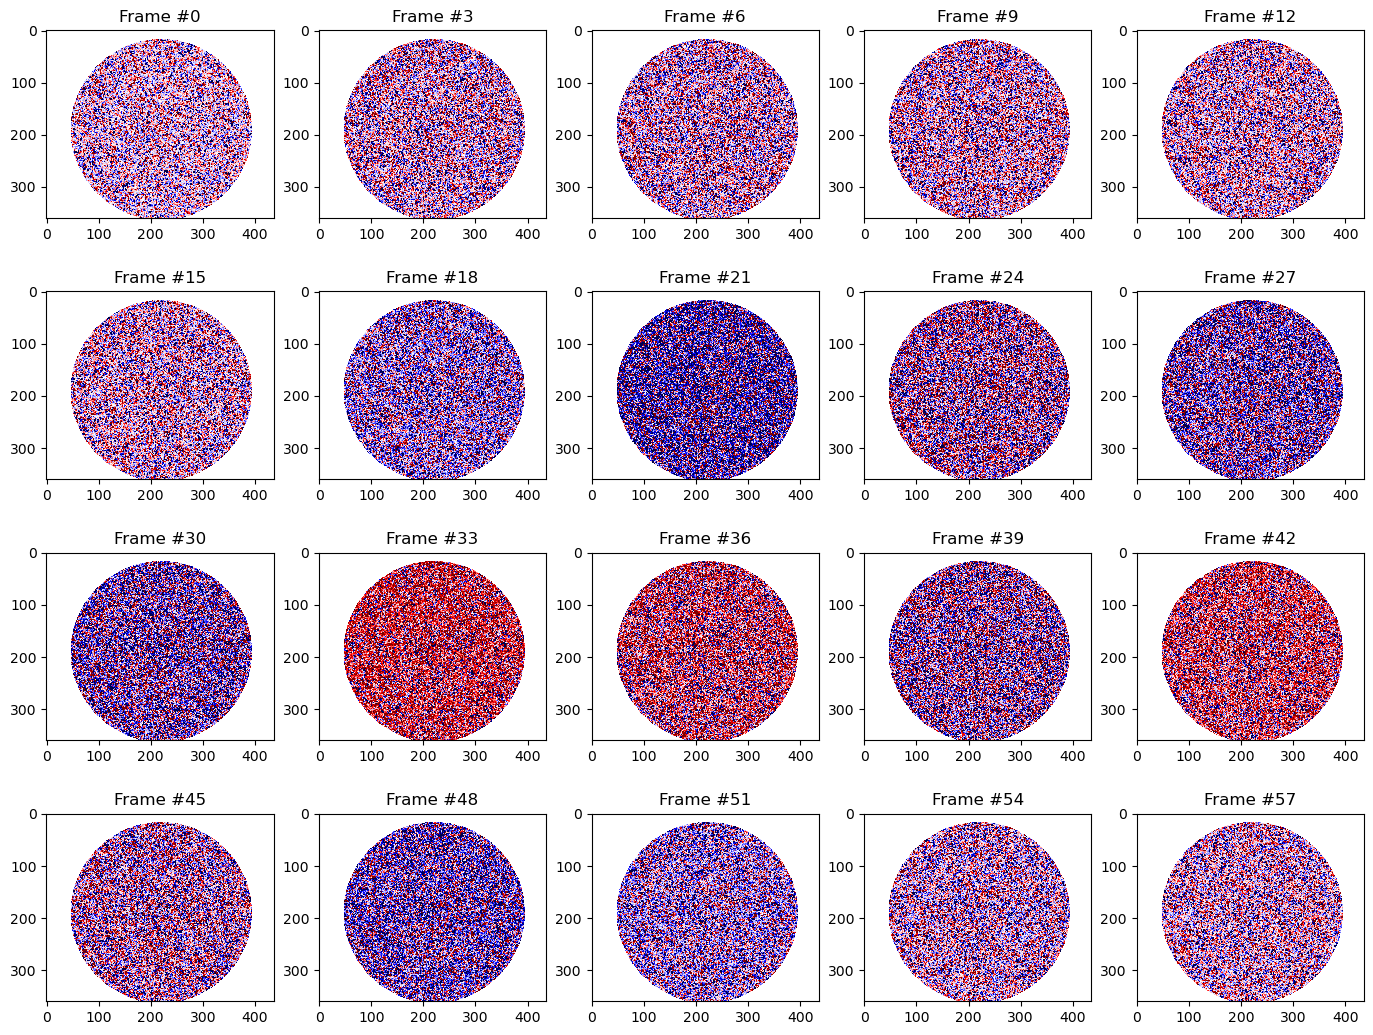

In [59]:
fig, axs = plt.subplots(4,5, figsize=(17,13))
for k in range(60):
    if k%3==0:
        ind=k//3
        axs[ind//5, ind%5].imshow(Trial_denoised_smart[k], cmap='seismic', vmin=-5, vmax=5)
        axs[ind//5, ind%5].set_title("Frame #"+str(k))

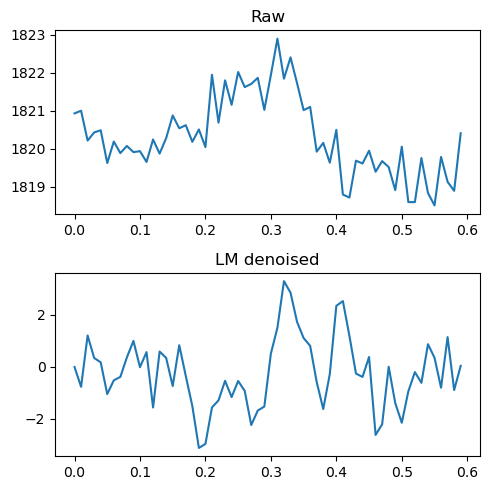

In [60]:
ts = np.nanmean(Trial, axis=(1,2))
ts_denoised = np.nanmean(Trial_denoised_smart, axis=(1,2))

fig, (ax1,ax2)=plt.subplots(2,1, figsize=(5,5), tight_layout=True)
ax1.set_title('Raw')
ax1.plot(time, ts)
ax2.set_title('LM denoised')
ax2.plot(time, ts_denoised)